In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn import neighbors
import seaborn as sns
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder

import matplotlib.pyplot as plt

# Forceasting with decompasable model
from pylab import rcParams
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller

# Datetime operations
import time

# Visualisation
import seaborn as sns
plt.style.use('fivethirtyeight')
import pickle
import gc
import warnings
warnings.filterwarnings("ignore")

C:\Users\jjk84\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
import os
os.getcwd()
os.chdir('C:/Users/jjk84/Downloads/kaggle')

In [3]:
start = time.time()
prop_2016 = pd.read_csv('./properties_2016.csv')
train_2016 = pd.read_csv("./train_2016_v2.csv")
prop_2017 = pd.read_csv('./properties_2017.csv')
train_2017 = pd.read_csv('./train_2017.csv')
sub=pd.read_csv('./sample_submission.csv')
end = time.time()
for c, dtype in zip(prop_2016.columns, prop_2016.dtypes):	
    if dtype == np.float64:		
        prop_2016[c] = prop_2016[c].astype(np.float32)
        
for c, dtype in zip(prop_2017.columns, prop_2017.dtypes):	
    if dtype == np.float64:		
        prop_2017[c] = prop_2017[c].astype(np.float32)

In [4]:
ref_2017=prop_2017[prop_2017.latitude.isnull()].parcelid
na_2017=prop_2016.query('parcelid in @ref_2017')
prop_2017_2=prop_2017[prop_2017.latitude.notnull()].append(na_2017)
# 2016년 데이터 기준
ref_2016=prop_2016[prop_2016.latitude.isnull()].parcelid
na_2016=prop_2017.query('parcelid in @ref_2016')
prop_2016_2=prop_2016[prop_2016.latitude.notnull()].append(na_2016)

In [5]:
#Identify numerical columns to produce a heatmap
catcols = ['airconditioningtypeid','architecturalstyletypeid','buildingqualitytypeid','buildingclasstypeid','decktypeid','fips','hashottuborspa','heatingorsystemtypeid','pooltypeid10','pooltypeid2','pooltypeid7','propertycountylandusecode','propertylandusetypeid','propertyzoningdesc','rawcensustractandblock','regionidcity','regionidcounty','regionidneighborhood','regionidzip','storytypeid','typeconstructiontypeid','yearbuilt','taxdelinquencyflag']
numcols = [x for x in prop_2017_2.columns if x not in catcols]

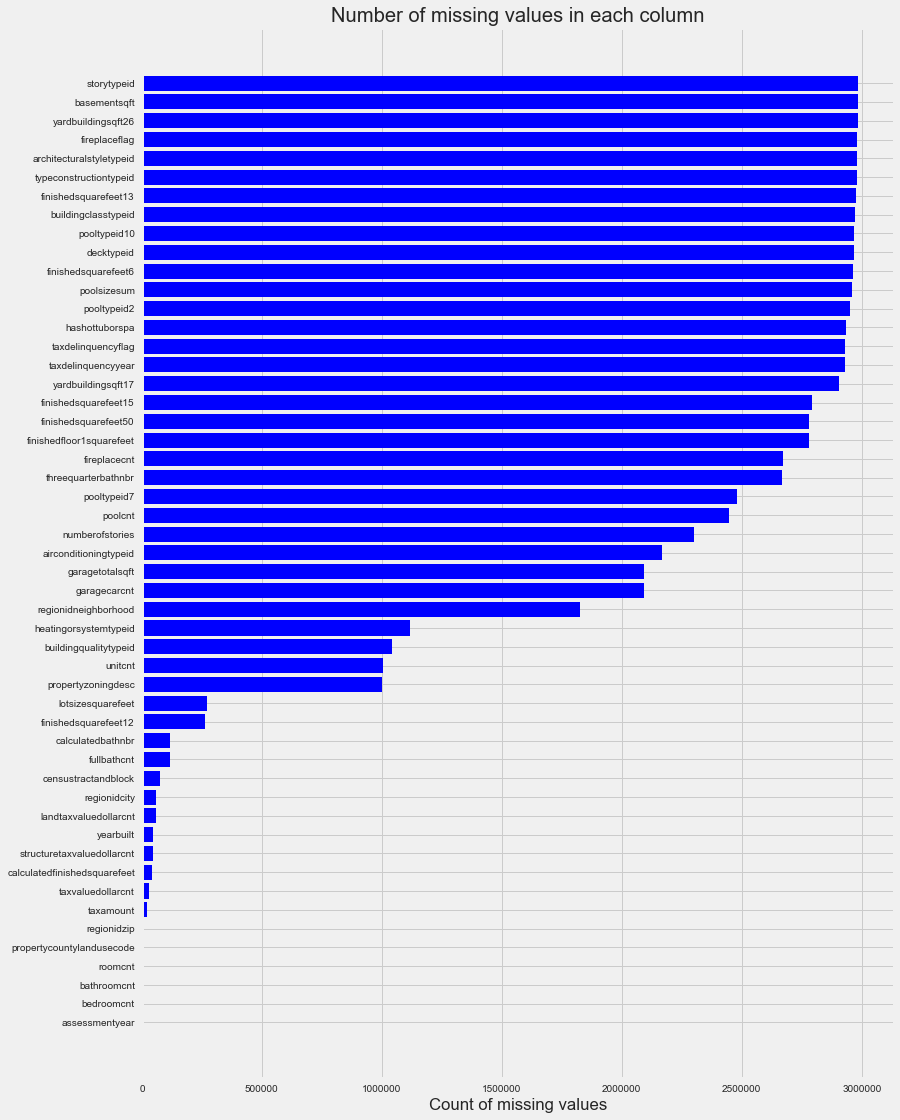

In [6]:
missing_df = prop_2017_2.isnull().sum(axis=0).reset_index()
missing_df.columns = ['column_name', 'missing_count']
missing_df = missing_df.loc[missing_df['missing_count']>0]
missing_df = missing_df.sort_values(by='missing_count')

ind = np.arange(missing_df.shape[0])
width = 0.9
fig, ax = plt.subplots(figsize=(12,18))
rects = ax.barh(ind, missing_df.missing_count.values, color='blue')
ax.set_yticks(ind)
ax.set_yticklabels(missing_df.column_name.values, rotation='horizontal')
ax.set_xlabel("Count of missing values")
ax.set_title("Number of missing values in each column")
plt.show()

In [7]:
#'calculatedfinishedsquarefeet' has the fewest missing values so lets remove the others, note also that except for 'finishedsquarefeet12' the rest have large amount of missing values anyways. 
#Also if you look at my script in https://www.kaggle.com/nikunjm88/creating-additional-features 'calculatedfinishedsquarefeet' appears to be the most important variable
dropcols = ['finishedsquarefeet12','finishedsquarefeet13', 'finishedsquarefeet15','finishedsquarefeet6']

#finishedsquarefeet50 and finishedfloor1squarefeet are the exactly the same information according to the dictionary descriptions, lets remove finishedsquarefeet50 as it has more missing values
dropcols.append('finishedsquarefeet50')

#'bathroomcnt' and 'calculatedbathnbr' and 'fullbathcnt' seem to be the same information aswell according to the dictionary descriptions. Choose 'bathroomcnt' as has no missing values, so remove the other two
dropcols.append('calculatedbathnbr')
dropcols.append('fullbathcnt')

In [8]:
#The below variables are flags and lets assume if they are NA's it means the object does not exist so lets fix this
index = prop_2017_2.hashottuborspa.isnull()
prop_2017_2.loc[index,'hashottuborspa'] = "None"

# pooltypeid10(does home have a Spa or hot tub) seems to be inconcistent with the 'hashottuborspa' field - these two fields should have the same information I assume?
print(prop_2017_2.hashottuborspa.value_counts())
print(prop_2017_2.pooltypeid10.value_counts())

#lets remove 'pooltypeid10' as has more missing values
dropcols.append('pooltypeid10')

#Assume if the pooltype id is null then pool/hottub doesnt exist 
index = prop_2017_2.pooltypeid2.isnull()
prop_2017_2.loc[index,'pooltypeid2'] = 0

index = prop_2017_2.pooltypeid7.isnull()
prop_2017_2.loc[index,'pooltypeid7'] = 0

index = prop_2017_2.poolcnt.isnull()
prop_2017_2.loc[index,'poolcnt'] = 0

None    2935152
True      50065
Name: hashottuborspa, dtype: int64
1.0    17008
Name: pooltypeid10, dtype: int64


In [9]:
#Theres more missing values in the 'poolsizesum' then in 'poolcnt', Let's fill in median values for poolsizesum where pool count is >0 and missing. I think this is sensible assumption as residential pool sizes are fairly standard size I guess in the U.S.
#Also the poolsizesum doesn't seem to be much of an important variable (https://www.kaggle.com/nikunjm88/creating-additional-features) so imputing with the median hopefully won't cause too much of an issue
print(prop_2017_2.poolsizesum.isnull().sum())
print(prop_2017_2.poolcnt.value_counts())

#Fill in those properties that have a pool with median pool value
poolsizesum_median = prop_2017_2.loc[prop_2017_2['poolcnt'] > 0, 'poolsizesum'].median()
prop_2017_2.loc[(prop_2017_2['poolcnt'] > 0) & (prop_2017_2['poolsizesum'].isnull()), 'poolsizesum'] = poolsizesum_median

#If it doesn't have a pool then poolsizesum is 0 by default
prop_2017_2.loc[(prop_2017_2['poolcnt'] == 0), 'poolsizesum'] = 0

2957258
0.0    2445523
1.0     539694
Name: poolcnt, dtype: int64


In [10]:
#There seems to be inconsistency between the fireplaceflag and fireplace cnt - my guess is that these should be the same
print(prop_2017_2.fireplaceflag.isnull().sum())
print(prop_2017_2.fireplacecnt.isnull().sum())

#There seems to be 80668 properties without fireplace according to the 'fireplacecnt' but the 'fireplace flag' says they are 90053 missing values
#Lets instead create the fireplaceflag from scratch using 'fireplacecnt' as there are less missing values here
prop_2017_2['fireplaceflag']= "No"
prop_2017_2.loc[prop_2017_2['fireplacecnt']>0,'fireplaceflag']= "Yes"

index = prop_2017_2.fireplacecnt.isnull()
prop_2017_2.loc[index,'fireplacecnt'] = 0

#Tax deliquency flag - assume if it is null then doesn't exist
index = prop_2017_2.taxdelinquencyflag.isnull()
prop_2017_2.loc[index,'taxdelinquencyflag'] = "None"

2980054
2672086


In [11]:
#Same number of missing values between garage count and garage size - assume this is because when there are properties with no garages then both variables are NA
print(prop_2017_2.garagecarcnt.isnull().sum())
print(prop_2017_2.garagetotalsqft.isnull().sum())

#Assume if Null in garage count it means there are no garages
index = prop_2017_2.garagecarcnt.isnull()
prop_2017_2.loc[index,'garagecarcnt'] = 0

#Likewise no garage means the size is 0 by default
index = prop_2017_2.garagetotalsqft.isnull()
prop_2017_2.loc[index,'garagetotalsqft'] = 0

#Let's fill in some missing values using the most common value for those variables where this might be a sensible approach
#AC Type - Mostly 1's, which corresponds to central AC. Reasonable to assume most other properties are similar.
prop_2017_2['airconditioningtypeid'].value_counts()
index = prop_2017_2.airconditioningtypeid.isnull()
prop_2017_2.loc[index,'airconditioningtypeid'] = 1

2094074
2094074


In [12]:
#heating or system - Mostly 2, which corresponds to central heating so seems reasonable to assume most other properties have central heating  
print(prop_2017_2['heatingorsystemtypeid'].value_counts())
index = prop_2017_2.heatingorsystemtypeid.isnull()
prop_2017_2.loc[index,'heatingorsystemtypeid'] = 2

2.0     1168952
7.0      646180
6.0       27481
24.0      21108
20.0       3631
13.0       1342
18.0        586
1.0         262
14.0         41
10.0         39
12.0         25
11.0         16
21.0          3
19.0          1
Name: heatingorsystemtypeid, dtype: int64


In [13]:
# 'threequarterbathnbr' - not an important variable according to https://www.kaggle.com/nikunjm88/creating-additional-features, so fill with most common value
print(prop_2017_2['threequarterbathnbr'].value_counts())
index = prop_2017_2.threequarterbathnbr.isnull()
prop_2017_2.loc[index,'threequarterbathnbr'] = 1

1.0    313556
2.0      2548
3.0       268
4.0        48
5.0        18
6.0         9
7.0         2
Name: threequarterbathnbr, dtype: int64


In [14]:
missingvalues_prop = (prop_2017_2.isnull().sum()/len(prop_2017_2)).reset_index()
missingvalues_prop.columns = ['field','proportion']
missingvalues_prop = missingvalues_prop.sort_values(by = 'proportion', ascending = False)
print(missingvalues_prop)
missingvaluescols = missingvalues_prop[missingvalues_prop['proportion'] > 0.97].field.tolist()
dropcols = dropcols + missingvaluescols
prop_2017_2 = prop_2017_2.drop(dropcols, axis=1)

                           field    proportion
41                   storytypeid  9.994560e-01
3                   basementsqft  9.994546e-01
46            yardbuildingsqft26  9.991133e-01
2       architecturalstyletypeid  9.979697e-01
43        typeconstructiontypeid  9.977399e-01
13          finishedsquarefeet13  9.974300e-01
6            buildingclasstypeid  9.957229e-01
29                  pooltypeid10  9.943026e-01
9                     decktypeid  9.941776e-01
16           finishedsquarefeet6  9.928032e-01
56            taxdelinquencyyear  9.810339e-01
45            yardbuildingsqft17  9.726693e-01
14          finishedsquarefeet15  9.357353e-01
10      finishedfloor1squarefeet  9.317333e-01
15          finishedsquarefeet50  9.317333e-01
48               numberofstories  7.702830e-01
38          regionidneighborhood  6.120691e-01
7          buildingqualitytypeid  3.493987e-01
44                       unitcnt  3.359896e-01
34            propertyzoningdesc  3.352862e-01
26           

In [15]:
def fillna_knn( df, base, target, fraction = 1, threshold = 10, n_neighbors = 5 ):
    assert isinstance( base , list ) or isinstance( base , np.ndarray ) and isinstance( target, str ) 
    whole = [ target ] + base
    
    miss = df[target].isnull()
    notmiss = ~miss 
    nummiss = miss.sum()
    
    enc = OneHotEncoder()
    X_target = df.loc[ notmiss, whole ].sample( frac = fraction )
    
    enc.fit( X_target[ target ].unique().reshape( (-1,1) ) )
    
    Y = enc.transform( X_target[ target ].values.reshape((-1,1)) ).toarray()
    X = X_target[ base  ]
    
    print( 'fitting' )
    n_neighbors = n_neighbors
    clf = neighbors.KNeighborsClassifier( n_neighbors, weights = 'uniform' )
    clf.fit( X, Y )
    
    print( 'the shape of active features: ' ,enc.active_features_.shape )
    
    print( 'predicting' )
    Z = clf.predict(df.loc[miss, base])
    
    numunperdicted = Z[:,0].sum()
    if numunperdicted / nummiss *100 < threshold :
        print( 'writing result to df' )    
        df.loc[ miss, target ]  = np.dot( Z , enc.active_features_ )
        print( 'num of unperdictable data: ', numunperdicted )
        return enc
    else:
        print( 'out of threshold: {}% > {}%'.format( numunperdicted / nummiss *100 , threshold ) )

#function to deal with variables that are actually string/categories
def zoningcode2int( df, target ):
    storenull = df[ target ].isnull()
    enc = LabelEncoder( )
    df[ target ] = df[ target ].astype( str )

    print('fit and transform')
    df[ target ]= enc.fit_transform( df[ target ].values )
    print( 'num of categories: ', enc.classes_.shape  )
    df.loc[ storenull, target ] = np.nan
    print('recover the nan value')
    return enc

In [16]:
#buildingqualitytypeid - assume it is the similar to the nearest property. Probably makes senses if its a property in a block of flats, i.e if block was built all at the same time and therefore all flats will have similar quality 
#Use the same logic for propertycountylandusecode (assume it is same as nearest property i.e two properties right next to each other are likely to have the same code) & propertyzoningdesc. 
#These assumptions are only reasonable if you actually have nearby properties to the one with the missing value

fillna_knn( df = prop_2017_2,
                  base = [ 'latitude', 'longitude' ] ,
                  target = 'buildingqualitytypeid', fraction = 0.15, n_neighbors = 1 )


zoningcode2int( df = prop_2017_2,
                            target = 'propertycountylandusecode' )
fillna_knn( df = prop_2017_2,
                  base = [ 'latitude', 'longitude' ] ,
                  target = 'propertycountylandusecode', fraction = 0.15, n_neighbors = 1 )

##zoningcode2int( df = prop_2017_2,
##                            target = 'propertyzoningdesc' )

##fillna_knn( df = prop_2017_2,
##                  base = [ 'latitude', 'longitude' ] ,
##                  target = 'propertyzoningdesc', fraction = 0.15, n_neighbors = 1 )

#regionidcity, regionidneighborhood & regionidzip - assume it is the same as the nereast property. 
#As mentioned above, this is ok if there's a property very nearby to the one with missing values (I leave it up to the reader to check if this is the case!)
fillna_knn( df = prop_2017_2,
                  base = [ 'latitude', 'longitude' ] ,
                  target = 'regionidcity', fraction = 0.15, n_neighbors = 1 )

##fillna_knn( df = prop_2017_2,
##                  base = [ 'latitude', 'longitude' ] ,
##                  target = 'regionidneighborhood', fraction = 0.15, n_neighbors = 1 )

fillna_knn( df = prop_2017_2,
                  base = [ 'latitude', 'longitude' ] ,
                  target = 'regionidzip', fraction = 0.15, n_neighbors = 1 )

#unitcnt - the number of structures the unit is built into. Assume it is the same as the nearest properties. If the property with missing values is in a block of flats or in a terrace street then this is probably ok - but again I leave it up to the reader to check if this is the case!
fillna_knn( df = prop_2017_2,
                  base = [ 'latitude', 'longitude' ] ,
                  target = 'unitcnt', fraction = 0.15, n_neighbors = 1 )

#yearbuilt - assume it is the same as the nearest property. This assumes properties all near to each other were built around the same time
fillna_knn( df = prop_2017_2,
                  base = [ 'latitude', 'longitude' ] ,
                  target = 'yearbuilt', fraction = 0.15, n_neighbors = 1 )

#lot size square feet - not sure what to do about this one. Lets use nearest neighbours. Assume it has same lot size as property closest to it
##fillna_knn( df = prop_2017_2,
##                  base = [ 'latitude', 'longitude' ] ,
##                 target = 'lotsizesquarefeet', fraction = 0.15, n_neighbors = 1 )

fitting
the shape of active features:  (12,)
predicting
writing result to df
num of unperdictable data:  188.0
fit and transform
num of categories:  (238,)
recover the nan value
fitting
the shape of active features:  (157,)
predicting
writing result to df
num of unperdictable data:  0.0
fitting
the shape of active features:  (185,)
predicting
writing result to df
num of unperdictable data:  75.0
fitting
the shape of active features:  (526,)
predicting


KeyboardInterrupt: 

In [20]:
#There are some properties where finishedfloor1squarefeet and calculatedfinishedsquarefeetare are both exactly the same - probably because its a studio flat of some sort so that the area on the first floor is equivalent to the total area, lets see how many there are
#For now assume if the number of stories is 1 then the finishedfloor1squarefeet is the same as calculatedfinishedsquarefeet
prop_2017_2.loc[(prop_2017_2['finishedfloor1squarefeet'].isnull()) & (prop_2017_2['numberofstories']==1),'finishedfloor1squarefeet'] = prop_2017_2.loc[(prop_2017_2['finishedfloor1squarefeet'].isnull()) & (prop_2017_2['numberofstories']==1),'calculatedfinishedsquarefeet']